In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jane-street-market-prediction/example_sample_submission.csv
/kaggle/input/jane-street-market-prediction/features.csv
/kaggle/input/jane-street-market-prediction/example_test.csv
/kaggle/input/jane-street-market-prediction/train.csv
/kaggle/input/jane-street-market-prediction/janestreet/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jane-street-market-prediction/janestreet/__init__.py


**This competition is evaluated on a utility score. Each row in the test set represents a trading opportunity for which you will be predicting an action value, 1 to make the trade and 0 to pass on it. Each trade j has an associated weight and resp, which represents a return.**

**We will import the main libraries to evaluate our model. However, we're not use all of them, just ones who brings
us a better results.**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression,RidgeCV, ElasticNet
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [3]:
df_train = pd.read_csv('/kaggle/input/jane-street-market-prediction/train.csv')
df_feat = pd.read_csv('/kaggle/input/jane-street-market-prediction/features.csv')
df_ex_sam = pd.read_csv('/kaggle/input/jane-street-market-prediction/example_sample_submission.csv')
df_ex = pd.read_csv('/kaggle/input/jane-street-market-prediction/example_test.csv')

In [4]:
def resizeplot(x,y,d):
    plt.figure(figsize=(x,y),dpi=d)

**Let's see our dataset**

In [5]:
df_train.head()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
0,0,0.000000,0.009916,0.014079,0.008773,0.001390,0.006270,1,-1.872746,-2.191242,...,NaN,1.168391,8.313583,1.782433,14.018213,2.653056,12.600292,2.301488,11.445807,0
1,0,16.673515,-0.002828,-0.003226,-0.007319,-0.011114,-0.009792,-1,-1.349537,-1.704709,...,NaN,-1.178850,1.777472,-0.915458,2.831612,-1.417010,2.297459,-1.304614,1.898684,1
2,0,0.000000,0.025134,0.027607,0.033406,0.034380,0.023970,-1,0.812780,-0.256156,...,NaN,6.115747,9.667908,5.542871,11.671595,7.281757,10.060014,6.638248,9.427299,2
3,0,0.000000,-0.004730,-0.003273,-0.000461,-0.000476,-0.003200,-1,1.174378,0.344640,...,NaN,2.838853,0.499251,3.033732,1.513488,4.397532,1.266037,3.856384,1.013469,3
4,0,0.138531,0.001252,0.002165,-0.001215,-0.006219,-0.002604,1,-3.172026,-3.093182,...,NaN,0.344850,4.101145,0.614252,6.623456,0.800129,5.233243,0.362636,3.926633,4


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float64(135), int64(3)
memory usage: 2.5 GB


**Let's check if there's some of null data.**

In [7]:
df_train[['date', 'weight', 'resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp','ts_id']].isnull().sum()

date      0
weight    0
resp_1    0
resp_2    0
resp_3    0
resp_4    0
resp      0
ts_id     0
dtype: int64

**Below is an example of one of our features and how it is distributed.**

<AxesSubplot:xlabel='weight', ylabel='Count'>

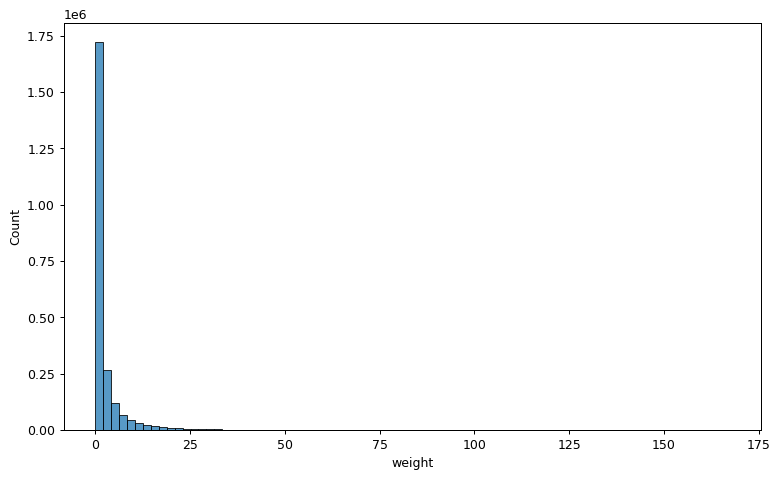

In [8]:
resizeplot(10,6,90)
sns.histplot(x=df_train['weight'],bins=80)

**Let's see how our data is correlated.**

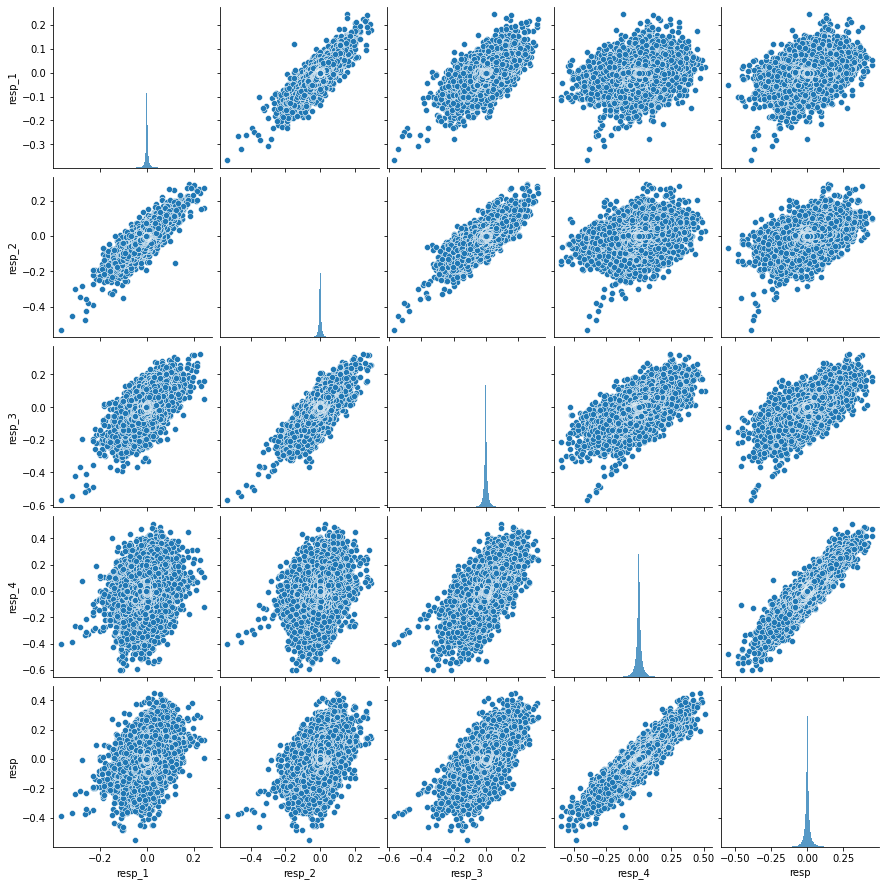

In [9]:
resp = df_train.iloc[:,2:7]
sns.pairplot(resp)

In [10]:
resp.describe()

,resp_1,resp_2,resp_3,resp_4,resp
count,2.390491e+06,2.390491e+06,2.390491e+06,2.390491e+06,2.390491e+06
mean,1.434969e-04,1.980749e-04,2.824183e-04,4.350201e-04,4.083113e-04
std,8.930163e-03,1.230236e-02,1.906882e-02,3.291224e-02,2.693609e-02
min,-3.675043e-01,-5.328334e-01,-5.681196e-01,-5.987447e-01,-5.493845e-01
25%,-1.859162e-03,-2.655044e-03,-5.030704e-03,-9.310415e-03,-7.157903e-03
50%,4.552665e-05,6.928179e-05,1.164734e-04,1.222579e-04,8.634997e-05
75%,2.097469e-03,2.939111e-03,5.466336e-03,9.804649e-03,7.544347e-03
max,2.453477e-01,2.949339e-01,3.265597e-01,5.113795e-01,4.484616e-01


In [11]:
df_train['action'] =np.where((df_train.resp_1 > 0) & (df_train.resp_2 > 0) & (df_train.resp_3 > 0) & (df_train.resp_4 > 0) & (df_train.resp > 0),1,0)

In [12]:
X = df_train[['date', 'weight', 'resp_1', 'resp_2', 'resp_3', 'resp_4', 'resp']]
y = df_train['action']

In [13]:
scaler = StandardScaler()
scale_X = scaler.fit_transform(X)

In [14]:
#GRID MODEL/ELASTIC NET

model_elastic = ElasticNet(alpha=0.1,l1_ratio=0.1)
#param_grid_en = {'alpha':[0.1,1,5,10,100,500],'l1_ratio':[.1,.7,.99,1]}
#grid_model_en = GridSearchCV(model_elastic,param_grid = param_grid_en,scoring='neg_mean_squared_error',
#                         cv=5,verbose=1)
model_elastic.fit(scale_X,y)
model_elastic = ElasticNet(alpha=0.1,l1_ratio=0.1)
model_elastic.fit(scale_X,y)

y_pred_en = model_elastic.predict(scale_X)
mae_net = mean_absolute_error(y,y_pred_en)
score_net = r2_score(y,y_pred_en)

print('Score_net: ', score_net)
print('Mae_net', mae_net)

Score_net:  0.23326596884217787
Mae_net 0.33283626002790884


In [15]:
#XGBOOST

#param_grid_x = {'n_estimators':[100],'verbosity':[1],'eval_metric':['mae'],
             #'max_depth':[6]}
xgb =XGBRegressor(n_estimators=100,verbosity=1,eval_metric='mae', max_depth=6)
#grid_xgb = GridSearchCV(xgb,param_grid_x,n_jobs=-1,cv=3)
xgb.fit(scale_X,y)
pred_xgb = xgb.predict(scale_X)
mae_xgb = mean_absolute_error(y,pred_xgb)
mse_xgb = mean_squared_error(y,pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y,pred_xgb))

score_xgb = r2_score(y,pred_xgb)

print('Score: ',score_xgb)
print('Mean_Absolute_error: ',mae_xgb)
print('Mean_Squared_Error: ',mse_xgb)
print('Root_Mean_Squared_Error: ',rmse_xgb)

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


Score:  0.9999999999898788
Mean_Absolute_error:  9.049563272492383e-07
Mean_Squared_Error:  1.979680915257104e-12
Root_Mean_Squared_Error:  1.407011341552407e-06


In [16]:
# Neural Nets

mlpr = MLPRegressor(activation= 'logistic',hidden_layer_sizes= (4,4), learning_rate= 'invscaling',
                    max_iter= 1000,solver= 'adam',verbose= True)
#param_grid = {'activation':['identity','logistic','relu'],'solver':['lbfgs', 'sgd', 'adam'],
             #'learning_rate':['constant','invscaling','adaptive'],'max_iter':[1000],
             #'verbose':['True'],'hidden_layer_sizes':[2,2]}

#grid_neural_cv = GridSearchCV(mlpr,param_grid,n_jobs=-1,cv=3)
mlpr.fit(scale_X,y)
grid_pred_neural = mlpr.predict(scale_X)
mae_neural = mean_absolute_error(y,grid_pred_neural)
mse_neural = mean_squared_error(y,grid_pred_neural)
rmse_neural = np.sqrt(mse_neural)
score_neural = r2_score(y,grid_pred_neural)
print('\n')
print('Score_neural: ', score_neural)
print('\n')
print('Mae_neural: ', mae_neural)
print('Mse_neural: ', mse_neural)
print('Rmse_neural: ', rmse_neural)

Iteration 1, loss = 0.03051277
Iteration 2, loss = 0.01412825
Iteration 3, loss = 0.01172583
Iteration 4, loss = 0.01114659
Iteration 5, loss = 0.01089392
Iteration 6, loss = 0.01075275
Iteration 7, loss = 0.01066003
Iteration 8, loss = 0.01059235
Iteration 9, loss = 0.01054148
Iteration 10, loss = 0.01049615
Iteration 11, loss = 0.01045998
Iteration 12, loss = 0.01042984
Iteration 13, loss = 0.01040080
Iteration 14, loss = 0.01037684
Iteration 15, loss = 0.01034676
Iteration 16, loss = 0.01031483
Iteration 17, loss = 0.01029027
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


Score_neural:  0.9038768537977837


Mae_neural:  0.044304508155121144
Mse_neural:  0.01880142518637444
Rmse_neural:  0.13711828902948883


In [17]:
# KNN REGRESSOR

knnr = KNeighborsRegressor(algorithm= 'auto', leaf_size= 100, n_neighbors= 15)
#param_knn_grid = {'n_neighbors':[5,15,20],'leaf_size':[100,200],
 #                 'algorithm':['auto']}
#grid_knnr = GridSearchCV(knnr,param_knn_grid,n_jobs=-1,cv=3)
#grid_knnr.fit(X,y)

knnr.fit(scale_X,y)
pred_knnr = knnr.predict(scale_X)

mae_knr = mean_absolute_error(y,pred_knnr)
mse_knr = mean_squared_error(y,pred_knnr)
rmse_knr = np.sqrt(mse_knr)

score_knnr = r2_score(y,pred_knnr)

print('Score: ',score_knnr)
print('\n')
print('Mean_Absolute_error: ',mae_knr)
print('Mean_Squared_Error: ',mse_knr)
print('Root_Mean_Squared_Error: ',rmse_knr)

Score:  0.9239346048814538


Mean_Absolute_error:  0.038429064712368045
Mean_Squared_Error:  0.014878183789206667
Root_Mean_Squared_Error:  0.12197616074137875


**Neural Networks shows us the best scores and results.**

In [18]:
action = pd.DataFrame(grid_pred_neural,columns=['Action'])
submission = pd.concat([df_train['ts_id'],action.astype(int)],axis=1)

In [19]:
action = np.round(action,1)

In [20]:
action = action.astype(int)

In [21]:
action.head(20)

,Action
0,0
1,0
2,1
3,0
4,0
5,0
6,0
7,1
8,0
9,1


In [22]:
submission = pd.concat([df_train['ts_id'],action],axis=1)

In [23]:
submission.tail(20)

,ts_id,Action
2390471,2390471,0
2390472,2390472,0
2390473,2390473,0
2390474,2390474,0
2390475,2390475,0
2390476,2390476,0
2390477,2390477,1
2390478,2390478,0
2390479,2390479,0
2390480,2390480,0


In [24]:
submission.to_csv('submission.csv',index=False)